# Project - Market Day

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" align="left" src="https://i.creativecommons.org/l/by-sa/4.0/80x15.png" /></a>&nbsp;| Dennis G. Wilson | <a href="https://supaerodatascience.github.io/stochastic/">https://supaerodatascience.github.io/stochastic/</a>


![Stardew Valley](https://venturebeat.com/wp-content/uploads/2018/01/sw7rtba7p1xs77klsime.png)


It is Market Day! You've been working hard for a whole season, planting, watering, and taking care of crops. Now it is time to sell them in town. Just one problem though - your old truck can only carry so much weight. Which crops should you bring to maximize your profits?


In this project, you will use a stochastic algorithm of your choice to find the best crop configuration you can load into your truck. You know how much stock you have of each crop, how much each crop weighs, and what price it will fetch at the market. You should use these values throughout the project.


Before we start, if you're using colab to run this notebook, you'll need to uncomment and run the following lines:


In [66]:
from typing import Dict, List, Callable

import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import pandas as pd

In [81]:
class CountCalls: 
    def __init__(self, func): 
        self._count = 0 
        self._func = func 
    def __call__( self, *args, **kwargs): 
        self._count += 1 
        return self._func(*args,**kwargs) 
    @property 
    def call_count(self): 
        return self._count 
    
    def reset_count(self):
        self._count = 0


In [2]:
df = pd.read_csv("market.csv", index_col=0)
df.head()


,stock,weight,price_A,price_B,price_C
Apple,5,5,1.00,0.5,1.1
Apricot,65,3,0.50,0.2,0.6
Blueberry,5,3,0.50,0.3,1.2
Cactus Fruit,90,4,0.75,0.3,0.3
Cherry,15,4,0.80,0.4,1.1


In [3]:
stock = df["stock"].to_dict()
weight = df["weight"].to_dict()
price = df["price_A"].to_dict()


To evaluate your possible load going to the market, we will use a function that takes in a dictionary of this type, specifying how many of each crop you will take. This function will take into the constraints of having enough stock of the crop type and of not surpassing the weight limit.


In [82]:
@CountCalls
def evaluate(
    load: Dict[str, int],
    stock: Dict[str, int],
    weight: Dict[str, int],
    price: Dict[str, int],
    max_weight=5000,
):
    total_weight = 0
    total_price = 0
    for k in load:
        if load[k] <= stock[k]:
            total_price += load[k] * price[k]
            total_weight += load[k] * weight[k]
            if total_weight > max_weight:
                return 0
        else:
            return 0
    return total_price


You can try this with an example load generated randomly:


In [5]:
trial_load = {}
for k in stock:
    trial_load[k] = np.random.randint(0, stock[k])


total_weight = 0
for k in trial_load:
    if trial_load[k] <= stock[k]:
        total_weight += trial_load[k] * weight[k]
print(f"{total_weight=}")

evaluate(trial_load, stock, weight, price, 5000)


total_weight=4375


701.85

In [63]:
evaluate({"Apricot": 10}, stock, weight, price)


5.0

## Challenge 1

Use a stochastic algorithm to find the configuration of crops that maximizes profit while respecting the constraints of the weight limit and stock. You can use any of the class code or a library like `pymoo`. You should create a reasonable representation for the problem and appropriate modification functions like mutation and crossover. You can also modify the evaluation function, as long as your final solution is valid according to the weight and stock constraints.

Include your code for optimization, any visualizations of the optimization process, as well as code to show the final market load and profit gained. Can you beat the random trial load profits?

Hint: this is a constrained case of the [knapsack problem](https://en.wikipedia.org/wiki/Knapsack_problem)


In [65]:
def get_random_load(stock):
    """util function to generate a random load matching provided available stock"""
    load = {}
    for k in stock:
        load[k] = np.random.randint(0, stock[k])
    return load


# random search method

In [83]:
def random_search(n_steps, stock, weight, price, evaluate: Callable, max_weight=5000):
    """function to perform a random search to maximise objective evaluate"""
    best_score = 0
    best_load = {}
    scores = np.empty(n_steps)
    evaluate.reset_count()

    for i in range(n_steps):
        random_load = get_random_load(stock)
        score = evaluate(random_load, stock, weight, price, max_weight)
        if score > best_score:
            best_score = score
            best_load = random_load
        scores[i] = best_score
    return best_load, best_score, scores


obtained a load priced 961.00 with 100000 evaluations of objective


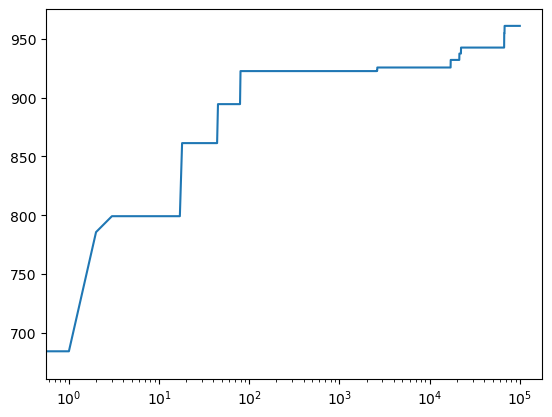

In [88]:
_, best_price, scores = random_search(100000, stock, weight, price, evaluate, 5000)
print(f"obtained a load priced {best_price:.2f} with {evaluate.call_count} evaluations of objective")
## best result yet : 981.55 with 100k iterations in ~5s

plt.plot(scores)
plt.xscale('log')

The results of random search are not that good. It takes *a lot* of evaluations to get a good result.

**We will try to use another method: genetic algorithm** to improve our results

In [71]:
def mutate(load: Dict[str, int], stock: Dict[str, int], proba=0.1):
    """
    permet d'avoir un chargement voisin qui respecte le stock
    ne modifie pas load, renvoie une nouvelle instance

    pour chaque culture ajoute + ou - 1 avec une probabilité proba,
    par défaut 10%, soit 5% pour +1 et 5% pour -1
    """
    new_load = load.copy()

    probas = np.random.rand(len(new_load.keys()))
    for idx, k in enumerate(new_load.keys()):
        if probas[idx] < proba / 2:
            # check if we can add 1 and still respect max load
            if stock[k] >= load[k] + 1:
                new_load[k] = load[k] + 1
        elif probas[idx] < proba:
            # check if we can subtract 1 and not be under 0
            if load[k] >= 0 + 1:
                new_load[k] = load[k] - 1

    return new_load


In [79]:
# example of what mutate changes in one load.
# In average it should change len(load)/proba (3.5) crop loads 
# (a little less in truth due to constraints on min/max values)

load = get_random_load(stock)
new_load = mutate(load, stock)

for k in load:
    if load[k] != new_load[k]:
        print(f"change to {k} load from {load[k]} to {new_load[k]}")


change to Pomegranate load from 1 to 0
change to Pumpkin load from 12 to 13
change to Red Cabbage load from 20 to 21


In [89]:
def crossover(load1: Dict[str, int], load2: Dict[str, int]) -> Dict[str, int]:
    """
    crossover entre deux stocks

    prend aléatoirement (p=0.5) le chargement de load1 ou load2 pour chaque culture
    """
    child = {}
    probas = np.random.rand(len(new_load.keys()))

    for idx, k in enumerate(load1.keys()):
        if probas[idx] > 0.5:
            child[k] = load1[k]
        else:
            child[k] = load2[k]

    return child


In [92]:
def tournament_selection(
    population: List[Dict[str, int]], fitness: npt.NDArray, t_size=3
):
    """returns the best individual in a random subset of population of size t_size"""
    rng = np.random.default_rng()
    tournament = rng.choice(len(population), size=t_size)
    ind = tournament[
        np.argmax(fitness[tournament])
    ]  # keep in mind we have to maximise fitness
    return population[ind], fitness[ind]


In [93]:
def truncation_selection(population: List[Dict[str, int]], fitness: npt.NDArray, p=0.2):
    """returns the best p*len(population) individuals"""
    
    n_elites = int(np.floor(len(population) * p))

    elites = np.argsort(fitness)[-n_elites:]  # keep in mind we have to maximise fitness

    return population[elites], fitness[elites]


In [96]:
def genetic_algorithm(
    population: List[Dict[str, int]],
    stock: Dict[str, int],
    weight: Dict[str, int],
    price: Dict[str, int],
    fitness: npt.NDArray | None,
    max_weight=5000,
):
    """
    performs one iteration of genetic algorithm search
    """
    if fitness is None:
        fitness = np.empty(len(population))
        for idx, load in enumerate(population):
            fitness[idx] = evaluate(load, stock, weight, price, max_weight)

    next_pop, next_fitness = truncation_selection(population, fitness) # keep the 20% best individuals 

    while len(next_pop) < len(population):
        parent1, _ = tournament_selection(population, fitness)
        parent2, _ = tournament_selection(population, fitness)
        child = crossover(parent1, parent2)
        child = mutate(child, stock)
        next_pop = np.concatenate((np.array(next_pop), np.array([child])))
        next_fitness = np.concatenate(
            (next_fitness.flatten(), np.array([evaluate(child, stock, weight, price, max_weight)]))
        )

    return next_pop, next_fitness


In [104]:
n_gen = 1000
n_population = 70

population = np.array([get_random_load(stock) for _ in range(n_population)])
maxfit = np.zeros(n_gen)

fitness = None
evaluate.reset_count()
for i in range(n_gen):
    population, fitness = genetic_algorithm(
        population, stock, weight, price, fitness, 5000  # type: ignore
    )
    maxfit[i] = np.max(fitness)
    if i > 2 and maxfit[i] > maxfit[i - 1]:
        print(i, maxfit[i])

best_load = population[np.argmax(fitness)]  # type: ignore
print(f"obtained a load priced {maxfit[-1]:.2f} with {evaluate.call_count} evaluations of objective")

# best result 1141.95 in 5000 iterations with 100 population and default mutation params
# it does not seem like we can get better results with this algorithm and those params.


3 951.5500000000001
4 956.7500000000001
5 975.75
6 977.8
7 991.95
8 1002.7500000000001
10 1003.5500000000001
11 1010.2000000000002
13 1013.6500000000002
14 1018.4500000000002
15 1025.8500000000004
16 1029.4
17 1032.6000000000001
19 1034.2
20 1034.9000000000003
21 1040.0
22 1044.8500000000001
23 1049.3000000000002
24 1051.5500000000002
25 1054.55
26 1056.1499999999999
27 1058.0000000000002
31 1061.3000000000002
33 1062.15
34 1062.95
35 1064.6499999999999
36 1065.2
39 1065.7
40 1065.8999999999999
41 1066.35
42 1066.6499999999999
44 1067.5500000000002
45 1068.1999999999998
46 1068.3999999999999
48 1068.7500000000002
50 1072.1000000000001
53 1072.25
54 1072.75
55 1073.3500000000001
56 1073.3999999999999
58 1073.55
60 1075.6
62 1076.95
63 1077.3999999999999
64 1077.8500000000001
67 1079.3999999999999
71 1080.1999999999998
72 1080.4999999999998
73 1081.45
77 1082.1
78 1082.7
79 1084.3499999999997
85 1085.4
87 1086.1499999999999
89 1088.0500000000002
92 1088.5
93 1088.85
94 1088.95
95 1090.35

On obtient de **bien meilleurs résultats** qu'en random search, pour un nombre d'évaluations de la fonction objectif plus faible. Ce nombre d'évaluation est quand même assez conséquent, une augmentation de la proportion des meilleurs individus à garder (paramètre p dans truncation_selection) permettrait de le réduire. On pourrait aussi changer le type de crossover et les paramètres de mutation pour espérer avoir de meilleurs résultats.
<br><br>
On voit que la convergence est <b>rapide au début puis très lente</b>.<br>Peut-être faudra-il ajouter plus de diversité / garder plus d'individus mauvais ? Changer la méthode de crossover pour faire une moyenne et non un choix aléatoire ? Il n'y a peut-être tout simplement pas de meilleur distribution que celle obtenant un prix de 1141.95, d'où la convergence lente en se rapprochant de cet objectif.


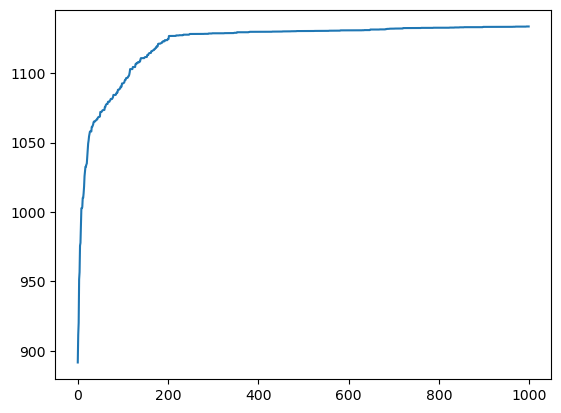

In [105]:
plt.plot(maxfit)


## Challenge 2


The agricultural market in this world is highly variable. This time, you'll be selling your load to a reseller, but you're not sure which one. Each reseller has different prices, so it depends on which one you'll meet. To be prepared, you should explore the possible options.


In [204]:
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.core.problem import ElementwiseProblem

from pymoo.operators.sampling.rnd import IntegerRandomSampling
from pymoo.optimize import minimize
from pymoo.core.crossover import Crossover
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PolynomialMutation
from pymoo.operators.mutation.pm import PM
from pymoo.core.mutation import Mutation

from pymoo.operators.repair.rounding import RoundingRepair

from pymoo.algorithms.moo.nsga2 import NSGA2, RankAndCrowdingSurvival
from pymoo.operators.crossover.ux import UniformCrossover



In [33]:
price_a = df["price_A"].to_dict()
price_b = df["price_B"].to_dict()
price_c = df["price_C"].to_dict()

prices = [price_a, price_b, price_c]


In [65]:
for idx, (key, value) in enumerate(df["price_C"].items()):
    print(f"{idx=} {key=} price={value} ")


idx=0 key='Apple' price=1.1 
idx=1 key='Apricot' price=0.6 
idx=2 key='Blueberry' price=1.2 
idx=3 key='Cactus Fruit' price=0.3 
idx=4 key='Cherry' price=1.1 
idx=5 key='Cranberry' price=0.4 
idx=6 key='Grape' price=0.5 
idx=7 key='Melon' price=1.1 
idx=8 key='Orange' price=0.8 
idx=9 key='Peach' price=0.6 
idx=10 key='Pomegranate' price=1.2 
idx=11 key='Rhubarb' price=0.5 
idx=12 key='Starfruit' price=0.4 
idx=13 key='Strawberry' price=1.0 
idx=14 key='Amaranth' price=1.0 
idx=15 key='Artichoke' price=0.6 
idx=16 key='Beet' price=0.9 
idx=17 key='Bok Choy' price=0.7 
idx=18 key='Cauliflower' price=0.5 
idx=19 key='Corn' price=0.3 
idx=20 key='Eggplant' price=0.3 
idx=21 key='Garlic' price=0.2 
idx=22 key='Green Bean' price=0.7 
idx=23 key='Hops' price=0.4 
idx=24 key='Hot Pepper' price=1.0 
idx=25 key='Kale' price=1.1 
idx=26 key='Parsnip' price=1.1 
idx=27 key='Potato' price=0.6 
idx=28 key='Pumpkin' price=0.2 
idx=29 key='Radish' price=0.7 
idx=30 key='Red Cabbage' price=0.6 
idx=31

In [20]:
price_a["Cherry"], price_b["Cherry"], price_c["Cherry"]


(0.8, 0.4, 1.1)

Given that cherries have very different prices between the different resellers, the example load we made ealier would fetch a wildly different price depending on the reseller:


In [21]:
a = evaluate(trial_load, stock, weight, price_a)
b = evaluate(trial_load, stock, weight, price_b)
c = evaluate(trial_load, stock, weight, price_c)
print(a, b, c)


701.1 319.7 463.2999999999999


In [31]:
print(len(stock))
len(list(stock.values()))


35


35

In [55]:
def evaluate_pymoo(
    load: List[int],
    stock: Dict[str, int],
    weight: Dict[str, int],
    price: Dict[str, int],
    max_weight=5000,
):
    total_weight = 0
    total_price = 0
    for idx, key in enumerate(price.keys()):
        if load[idx] <= stock[key]:
            total_price += load[idx] * price[key]
            total_weight += load[idx] * weight[key]
            if total_weight > max_weight:
                return 0
        else:
            return 0
    return total_price


In [225]:
np.array(list(stock.values()))

array([ 5, 65,  5, 90, 15, 75, 70, 75, 40, 55,  5, 70,  5, 20, 20, 65, 30,
       55, 70, 90, 95, 95, 55, 75, 25,  5, 10, 55, 30, 50, 55, 65, 75, 50,
       70])

In [224]:
# algorith = GA(pop_size=100, )


class MarketProblemMultiSeller(ElementwiseProblem):
    stock: Dict[str, int]
    weight: Dict[str, int]
    prices: pd.DataFrame
    prices_columns: List[str]
    max_weight: int
    xl: npt.NDArray[np.int32]
    xu: npt.NDArray[np.int32]

    def __init__(
        self,
        stock: Dict[str, int],
        weight: Dict[str, int],
        prices: pd.DataFrame,
        prices_columns: List[str] = ["price_A", "price_B", "price_C"],
        max_weight=5000,
    ):
        self.stock = stock
        self.weight = weight
        self.prices = prices
        self.prices_columns = prices_columns
        self.max_weight = max_weight

        # super(MarketProblemMultiSeller, self).__init__(
        super().__init__(
            n_obj=3,
            n_var=len(stock),
            n_ieq_constr=1,
            xl=np.zeros(len(stock)),
            xu=np.array(list(stock.values()), dtype=np.int32),
        )

    def _evaluate(self, x, out, *args, **kwargs):
        total_weight = np.sum(x * np.array(list(self.weight.values())))

        # create prices data
        total_price = {column: 0 for column in self.prices_columns}

        for column in self.prices_columns:
            for idx, (_, price) in enumerate(self.prices[column].items()):
                total_price[column] += x[idx] * price

        out["F"] = np.array([-price for price in total_price.values()])
        out["G"] = total_weight - self.max_weight
        return


In [ ]:
def pymoo_crossover(indiv1: list[int], indiv2: list[int]) -> List[int]:
    """
    crossover entre deux stocks

    prend aléatoirement (p=0.5) le chargement de load1 ou load2 pour chaque culture
    """
    child = np.empty(len(indiv1), dtype=np.int64)
    probas = np.random.rand(len(indiv1))

    for i in range(len(indiv1)):
        if probas[i] > 0.5:
            child[i] = indiv1[i]
        else:
            child[i] = indiv2[i]

    return list(child)


In [ ]:
class PymooCrossover(Crossover):
    def __init__(self):

        # define the crossover: number of parents and number of offsprings
        super().__init__(2, 2)

    def _do(self, problem, X, **kwargs):

        # The input of has the following shape (n_parents, n_matings, n_var)
        _, n_matings, n_var = X.shape

        # The output owith the shape (n_offsprings, n_matings, n_var)
        # Because there the number of parents and offsprings are equal it keeps the shape of X
        Y = np.full_like(X, None, dtype=object)

        # for each mating provided
        for k in range(n_matings):

            # get the first and the second parent
            a, b = X[0, k, 0], X[1, k, 0]

            # prepare the offsprings
            off_a = ["_"] * problem.n_characters
            off_b = ["_"] * problem.n_characters

            for i in range(problem.n_characters):
                if np.random.random() < 0.5:
                    off_a[i] = a[i]
                    off_b[i] = b[i]
                else:
                    off_a[i] = b[i]
                    off_b[i] = a[i]

            # join the character list and set the output
            Y[0, k, 0], Y[1, k, 0] = "".join(off_a), "".join(off_b)

        return Y


In [226]:
class MutateLoad(Mutation):
    # def __init__(self, prob=0.9, eta=20, at_least_once=False, **kwargs):
    #     super().__init__(prob=prob, **kwargs)

    def _do(self, problem: MarketProblemMultiSeller, X: npt.NDArray, **kwargs):
        """
        permet d'avoir un chargement voisin qui respecte le stock
        ne modifie pas load, renvoie une nouvelle instance. inplace

        pour chaque culture ajoute + ou - 1 avec une probabilité proba,
        par défaut 10%, soit 5% pour +1 et 5% pour -1
        """
        threshold = 0.1

        # iterate over all loads contained in X
        for load_idx in range(X.shape[0]):
            probas = np.random.rand(len(X))

            # iterate over all the variables in one load
            for crop_idx, (crop_amount, proba) in enumerate(zip(X[load_idx], probas)):
                if proba < threshold / 2:
                    # check if we can add 1 and still respect max load
                    if crop_amount + 1 <= problem.xu[crop_idx]:
                        X[load_idx][crop_idx] = crop_amount + 1
                elif proba < threshold:
                    # check if we can subtract 1 and not be under 0
                    if crop_amount >= problem.xl[crop_idx] + 1:
                        X[load_idx][crop_idx] = crop_amount - 1

        return X


In [235]:
algorithm = NSGA2(
    pop_size=100,
    n_offsprings=100,
    eliminate_duplicates=True,
    mutation=MutateLoad(),
    crossover=UniformCrossover(repair=RoundingRepair()),
    survival=RankAndCrowdingSurvival(),
    sampling=IntegerRandomSampling(),
)  # the uniform crossover perform the same crossover as we did before


In [236]:
problem = MarketProblemMultiSeller(stock, weight, df)


In [237]:
res = minimize(
    problem,
    algorithm,
    termination=("n_gen", 1000),
    # seed=1,
    save_history=True,
)

print("Best solution found: %s" % res.X)
print("Function value: %s" % res.F)
print("Constraint violation: %s" % res.CV)


Best solution found: [[ 5 12  4 ... 12 50  9]
 [ 5 12  4 ... 12 50 10]
 [ 5 56  5 ... 10 50 69]
 ...
 [ 5 56  4 ... 10 50 66]
 [ 5 10  5 ... 10 50 10]
 [ 4 12  5 ... 10 50  7]]
Function value: [[ -865.1   -448.7   -541.6 ]
 [ -864.5   -448.6   -542.6 ]
 [-1056.25  -406.1   -725.5 ]
 [-1064.35  -404.3   -721.1 ]
 [ -923.05  -444.7   -568.  ]
 [ -880.65  -445.3   -558.5 ]
 [ -963.55  -441.3   -591.5 ]
 [ -945.85  -443.2   -562.1 ]
 [ -992.9   -431.9   -644.8 ]
 [ -954.4   -442.9   -573.1 ]
 [-1009.25  -422.7   -681.1 ]
 [ -979.25  -435.1   -627.3 ]
 [ -956.75  -442.3   -576.8 ]
 [ -994.15  -431.1   -650.4 ]
 [ -985.9   -433.5   -638.2 ]
 [ -961.    -441.5   -582.8 ]
 [ -960.35  -441.9   -581.8 ]
 [ -972.6   -439.    -603.9 ]
 [-1041.2   -413.    -695.2 ]
 [-1019.7   -428.5   -633.9 ]
 [ -987.7   -436.9   -615.1 ]
 [-1044.55  -419.2   -648.  ]
 [-1050.1   -411.7   -703.  ]
 [-1046.15  -408.9   -714.9 ]
 [ -944.2   -443.8   -564.7 ]
 [-1017.9   -424.3   -661.4 ]
 [ -970.4   -437.9   -612. 

In [230]:
def is_load_valid(load: npt.NDArray, stock: Dict[str, int], weight: Dict[str, int], max_weight = 5000) -> bool:
    load = load.flatten()
    
    if not (len(load) == len(stock) == len(weight)):
        print("dimensions do not correspond")
        return False
    
    total_weight=0

    for idx, (crop_quantity, crop_stock, crop_weight) in enumerate(zip(load, stock.values(), weight.values())):
        if crop_quantity > crop_stock or crop_quantity < 0:
            print(f"crop n°{idx} quantity ({crop_quantity}) does not correspond to stock {crop_stock}.")
            return False
        
        total_weight += crop_quantity * crop_weight

    if total_weight > max_weight:
        print(f"total weight {total_weight} is over max allowed weight of {max_weight}")
        return False
    return True


In [239]:
for x in res.X:
    if not is_load_valid(x, stock, weight):
        print(f"{x=} not valid")

Prepare four different options for your market day haul: one option that will be good for reseller A, one for reseller B, one for reseller C, and one which would be pretty good for all three. Display these options and compare their different prices.


Hint: you can use a multi-objective algorithm to optimize for all three reseller prices at the same time.


## Challenge 3


You decide to preprare some of your crops by making food for the market day. You know a number of recipes and are famous for your delicious fruit pies.


In [ ]:
recipes = {
    "Ratatouille": {"Eggplant": 2, "Garlic": 2, "Tomato": 4, "Hot Pepper": 1},
    "Apple Pie": {"Apple": 10, "Wheat": 5},
    "Apricot Pie": {"Apricot": 10, "Wheat": 5},
    "Cherry Pie": {"Cherry": 10, "Wheat": 5},
    "Rhubarb Pie": {"Rhubarb": 10, "Wheat": 5},
    "Strawberry Pie": {"Strawberry": 10, "Wheat": 5},
    "Blackberry Pie": {"Blackberry": 10, "Wheat": 5},
    "Pumpkin Pie": {"Pumpkin": 10, "Wheat": 5},
    "Pizza": {"Tomato": 3, "Wheat": 2, "Artichoke": 1},
    "Baba Ghanoush": {"Eggplant": 2, "Garlic": 4},
    "Squash Soup": {"Yam": 3, "Pumpkin": 1},
    "Peach Beer": {"Hops": 3, "Peach": 1},
    "Blackberry Beer": {"Hops": 3, "Blackberry": 1},
}


These recipes sell for good prices at each of the resellers:


In [ ]:
df = pd.read_csv("recipes.csv", index_col=0)
df.head()


In [ ]:
price_a.update(df["price_A"].to_dict())
price_b.update(df["price_B"].to_dict())
price_c.update(df["price_C"].to_dict())
price_a["Apple Pie"], price_b["Apple Pie"], price_c["Apple Pie"]


Modify the evaluation function to take into account these recipes, making sure not to break the weight or stock constraints. The weight of a recipe is the sum total weight of the ingredients, and you can not make a recipe if you don't have the remaining stock of ingredients. Here's an example of calculating the total weight of a random load of only recipes:


In [ ]:
recipe_load = {}
for k in recipes:
    recipe_load[k] = np.random.randint(0, 5)
recipe_load


In [ ]:
def get_weight(recipe_load, recipes, weight):
    total_weight = 0
    for k in recipe_load:
        ingredients = recipes[k]
        w = 0
        for i in ingredients:
            w += weight[i] * ingredients[i]
        total_weight += w * recipe_load[k]
    return total_weight


In [ ]:
get_weight(recipe_load, recipes, weight)


Once you've modified the evaluation function, rerun the optimization algorithm to find a new load for the three resellers, and one load which is good for all three. Display this result and the profit gained, making sure that the constraints are met.


## Evaluation


You should submit a saved copy of your notebook (including all of the cell output) to the LMS by December 13th, EOD. You may work with one partner, but you must **individually submit a notebook**. You will be graded based on your results, your code, and any text or visual explanations, according to the following rubric:

| Criterion                 | Points |
| ------------------------- | ------ |
| Results - Challenge 1     | 7      |
| Results - Challenge 2     | 5      |
| Results - Challenge 3     | 3      |
| Presentation (code, text) | 5      |
